In [1]:
import os
import pandas as pd
import geopandas as gpd
import plotly.express as px
import ast
%pylab inline

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 40000)
pd.set_option('display.max_rows', None)

df_safegraph_poi = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_POI_Yellowstone_200miRadius.csv.gz'))
df_safegraph_spend = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_SPEND_Yellowstone_200miRadius.csv.gz'))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
mask = df_safegraph_poi['CITY'] == 'West Yellowstone'
df_weyel_poi = df_safegraph_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_weyel = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_weyel_poi['PLACEKEY'])]
else:
    print("Error: DataFrame does not contain 'PLACEKEY' column.")

print(df_weyel.head(10))

                 PLACEKEY                        SAFEGRAPH_BRAND_IDS          BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND         TRANSACTION_INTERMEDIARY         SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_ME

## Functions

In [3]:
def time_filt(df, start, end):
    datetime_start = pd.to_datetime(start)
    datetime_end = pd.to_datetime(end)
    df_copy = df.copy()
    
    df_copy['SPEND_DATE_RANGE_START'] = pd.to_datetime(df_copy['SPEND_DATE_RANGE_START'])
    df_copy['SPEND_DATE_RANGE_END'] = pd.to_datetime(df_copy['SPEND_DATE_RANGE_END'])
    
    df_filtered = df_copy[(df_copy['SPEND_DATE_RANGE_START'] >= datetime_start) &
                                 (df_copy['SPEND_DATE_RANGE_END'] <= datetime_end)]
    
    return df_filtered


In [4]:
def percent_instate(df):
    home_city = df['CUSTOMER_HOME_CITY']
    in_state = 0
    out_state = 0

    for val in df['CUSTOMER_HOME_CITY']:
        cities = val.split(",")
        cities = cities[1::2]
        for i in cities:
            state = i.split(':')
            if(state[0].find("MT") != 1):
                count = state[1].strip("{}")
                out_state += int(count)
            else:
                count = state[1].strip("{}")
                in_state += int(count)
    
    print('Out of state: ', out_state)
    print('In state: ', in_state)
    print('Percentage out of state:', (out_state)/(in_state+out_state)*100, '%')
    
    return [in_state, out_state]

In [5]:
def percent_change_month(df):
    pct_change_month = df['SPEND_PCT_CHANGE_VS_PREV_MONTH'].dropna()
    
    sum = 0
    product = 1
    for val in pct_change_month:
        sum += val/100
        product *= val/100
    pct_change_total = (sum + product)*100
    return pct_change_total

In [6]:
def percent_change_year(df):
    pct_change_year = df['SPEND_PCT_CHANGE_VS_PREV_YEAR'].dropna()
    
    sum = 0
    product = 1
    for val in pct_change_year:
        sum += val/100
        product *= val/100
    pct_change_total = (sum + product)*100
    return pct_change_total

In [7]:
def spend_by_day(df):
    df_filtered = df.copy()

    # Convert string representations of lists in 'SPEND_BY_DAY' to actual lists
    df_filtered['SPEND_BY_DAY'] = df_filtered['SPEND_BY_DAY'].apply(ast.literal_eval)

    # Add a new column called 'DATE_OF_MONTH', as a list of integers from 1 to the end of the month (length of the 'SPEND_BY_DAY' list)
    df_filtered['DATE_OF_MONTH'] = df_filtered['SPEND_BY_DAY'].apply(lambda x: list(range(1, len(x) + 1)))

    df_spend_by_day = df_filtered.explode(['SPEND_BY_DAY', 'DATE_OF_MONTH'])

    df_spend_by_day['SPEND_BY_DAY'] = df_spend_by_day['SPEND_BY_DAY'].astype(float)
    df_spend_by_day['DATE_OF_MONTH'] = df_spend_by_day['DATE_OF_MONTH'].astype(int)

    df_spend_by_day['DATE'] = pd.to_datetime(df_spend_by_day['SPEND_DATE_RANGE_START']) + pd.to_timedelta(df_spend_by_day['DATE_OF_MONTH'] - 1, unit='D')

    df_grouped = df_spend_by_day.groupby('DATE')['SPEND_BY_DAY'].sum()

    return df_grouped

## General West Yellowstone, MT

In [8]:
df_weyel_flood = time_filt(df_weyel, '2022-05-01', '2022-08-01')
df_flood_spending = spend_by_day(df_weyel_flood)

before_flood = df_flood_spending[33:40]
during_flood = df_flood_spending[40:47]
after_flood = df_flood_spending[47:54]
print(before_flood)
print(during_flood)
print(after_flood)

DATE
2022-06-03     5660.46
2022-06-04     5688.48
2022-06-05     5991.00
2022-06-06    15351.72
2022-06-07    12317.55
2022-06-08    10358.94
2022-06-09     7642.35
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     9870.93
2022-06-11     4566.48
2022-06-12     8789.12
2022-06-13    35585.14
2022-06-14     6219.62
2022-06-15     4698.37
2022-06-16     4549.41
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17     5687.95
2022-06-18     2849.10
2022-06-19     4293.51
2022-06-20     3633.09
2022-06-21    15349.32
2022-06-22     8138.26
2022-06-23     3700.56
Name: SPEND_BY_DAY, dtype: float64


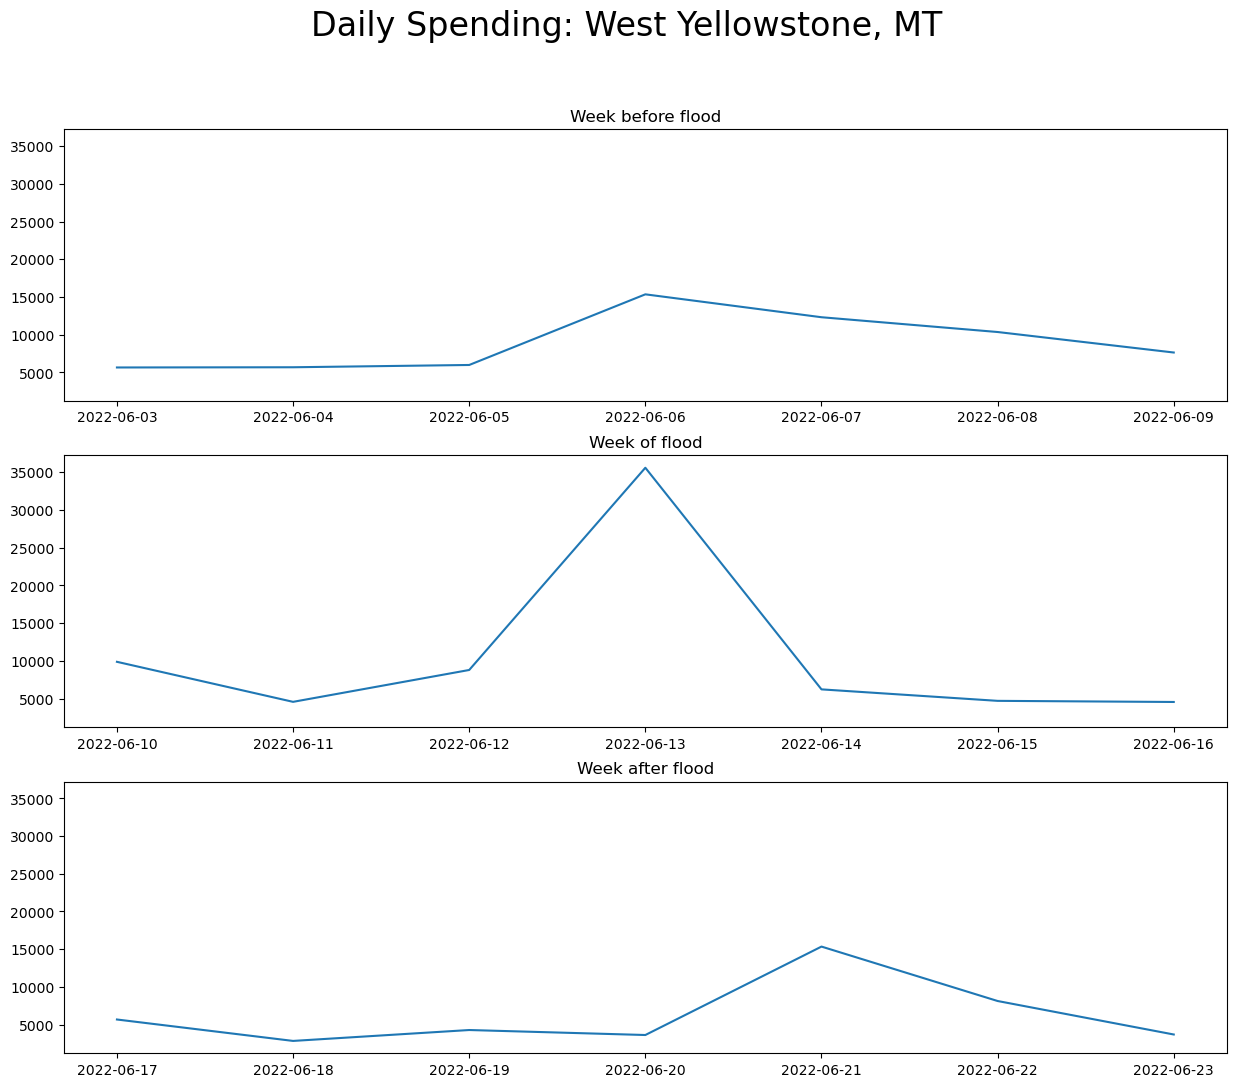

In [9]:
fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood)
ax1.set_title('Week before flood');
ax2.plot(during_flood)
ax2.set_title('Week of flood');
ax3.plot(after_flood)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending: West Yellowstone, MT', fontsize='24');

In [10]:
before_flood_start = '2022-05-01'
before_flood_end = '2022-06-01'

df_weyel_before = time_filt(df_weyel, before_flood_start, before_flood_end)

In [11]:
during_flood_start = '2022-06-01'
during_flood_end = '2022-07-01'

df_weyel_during = time_filt(df_weyel, during_flood_start, during_flood_end)

In [12]:
after_flood_start = '2022-07-01'
after_flood_end = '2022-08-01'

df_weyel_after = time_filt(df_weyel, after_flood_start, after_flood_end)

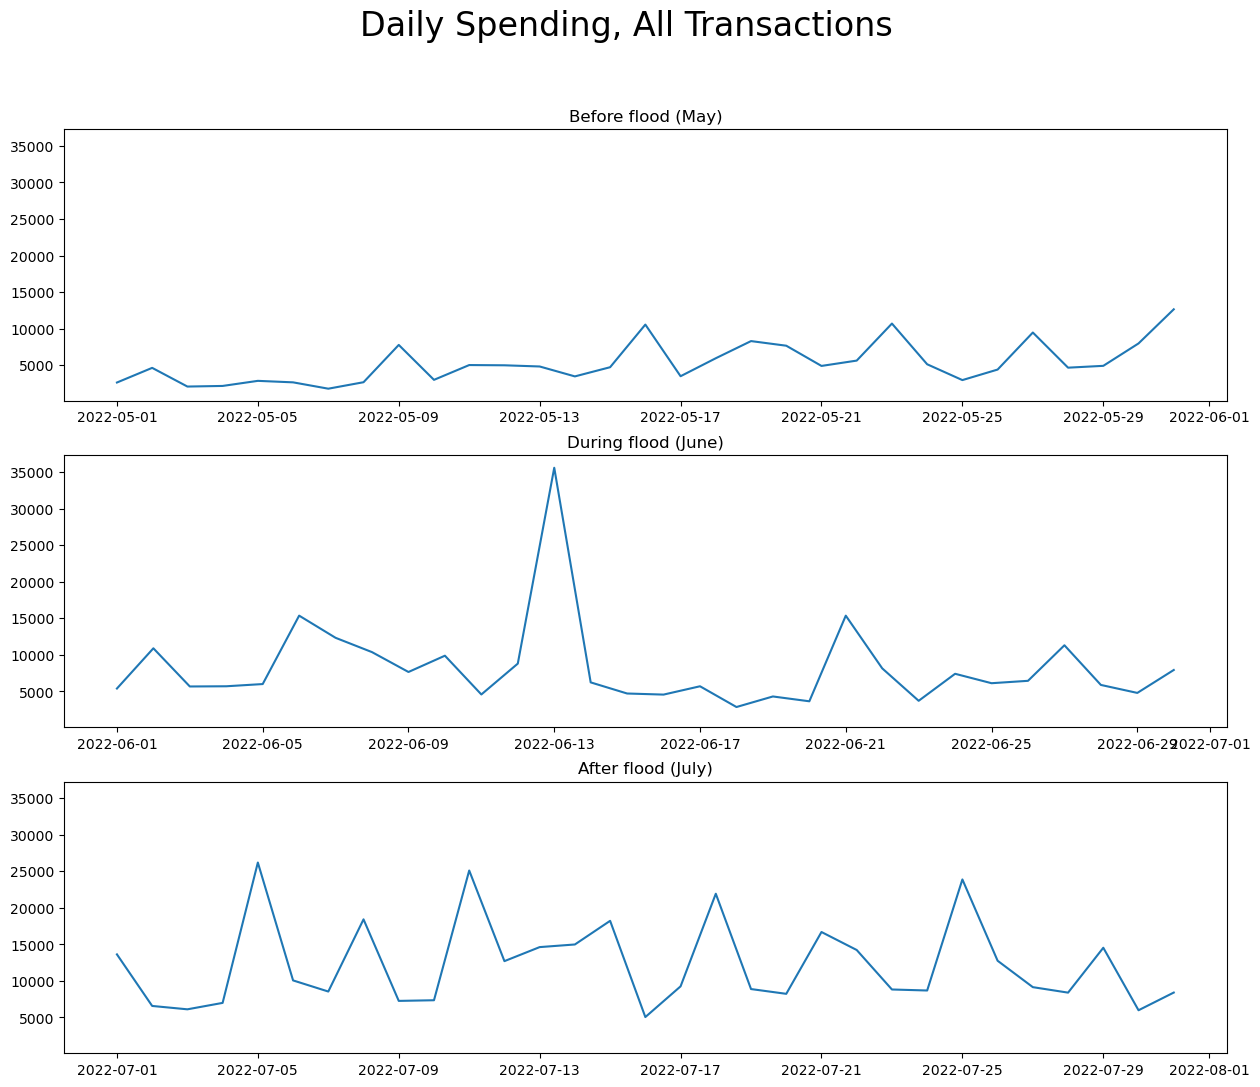

In [13]:
df_spend_before = spend_by_day(df_weyel_before)
df_spend_during = spend_by_day(df_weyel_during)
df_spend_after = spend_by_day(df_weyel_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(df_spend_before)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, All Transactions', fontsize='24');

In [14]:
print('Percent Change April to May: ')
print(percent_change_month(df_weyel_before), '%\n')

print('Percent Change May to Jume: ')
print(percent_change_month(df_weyel_during), '%\n')

print('Percent Change June to July: ')
print(percent_change_month(df_weyel_after), '%\n')

Percent Change April to May: 
114693689879.25859 %

Percent Change May to Jume: 
8290.000022385753 %

Percent Change June to July: 
6425.999999999999 %



In [15]:
print('Percent Change May 2021 to May 2022: ')
print(percent_change_year(df_weyel_before), '%\n')

print('Percent Change June 2021 to Jume 2022: ')
print(percent_change_year(df_weyel_during), '%\n')

print('Percent Change July 2021 to July 2022: ')
print(percent_change_year(df_weyel_after), '%\n')

Percent Change May 2021 to May 2022: 
236.00000000000003 %

Percent Change June 2021 to Jume 2022: 
-1172.0 %

Percent Change July 2021 to July 2022: 
1542.0000000000007 %



Before Flooding: 
Out of state:  3347
In state:  208
Percentage out of state: 94.14908579465542 %


During Flooding: 
Out of state:  4757
In state:  244
Percentage out of state: 95.12097580483903 %


After Flooding: 
Out of state:  6181
In state:  463
Percentage out of state: 93.03130644190247 %




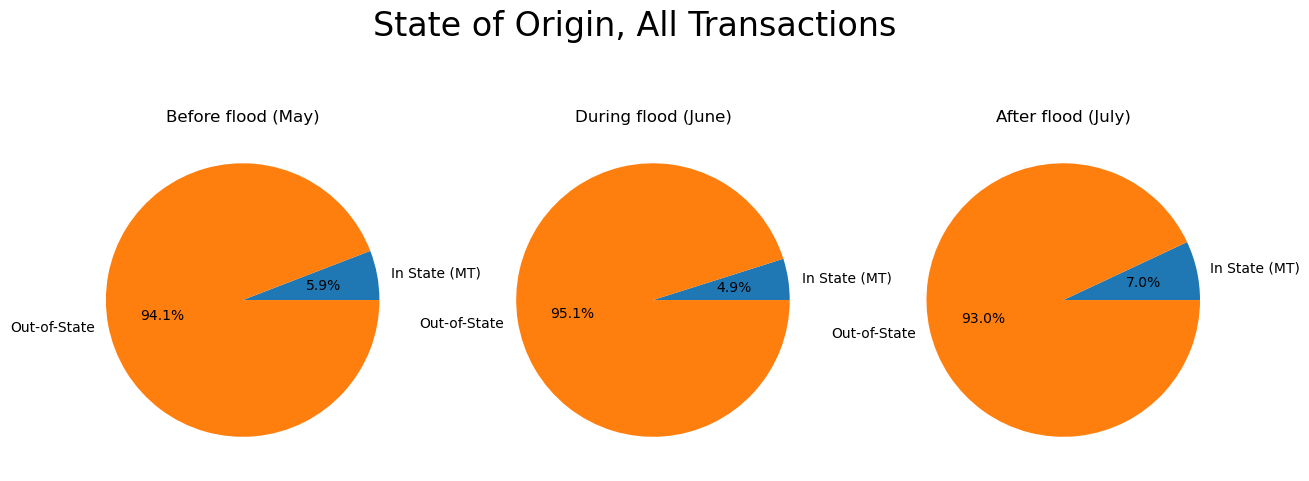

In [16]:
print('Before Flooding: ')
before = percent_instate(df_weyel_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_weyel_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_weyel_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));
ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');

fig.suptitle('State of Origin, All Transactions', fontsize='24');

In [17]:
month = ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', 
         '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01']

df_weyel_jan = time_filt(df_weyel, month[0], month[1])
df_weyel_feb = time_filt(df_weyel, month[1], month[2])
df_weyel_mar = time_filt(df_weyel, month[2], month[3])
df_weyel_apr = time_filt(df_weyel, month[3], month[4])
df_weyel_may = time_filt(df_weyel, month[4], month[5])
df_weyel_jun = time_filt(df_weyel, month[5], month[6])
df_weyel_jul = time_filt(df_weyel, month[6], month[7])
df_weyel_aug = time_filt(df_weyel, month[7], month[8])
df_weyel_sep = time_filt(df_weyel, month[8], month[9])
df_weyel_oct = time_filt(df_weyel, month[9], month[10])
df_weyel_nov = time_filt(df_weyel, month[10], month[11])
df_weyel_dec = time_filt(df_weyel, month[11], month[12])

month_dfs = [df_weyel_jan, df_weyel_feb, df_weyel_mar, df_weyel_apr, df_weyel_may, df_weyel_jun, 
             df_weyel_jul, df_weyel_aug, df_weyel_sep, df_weyel_oct, df_weyel_nov, df_weyel_dec]

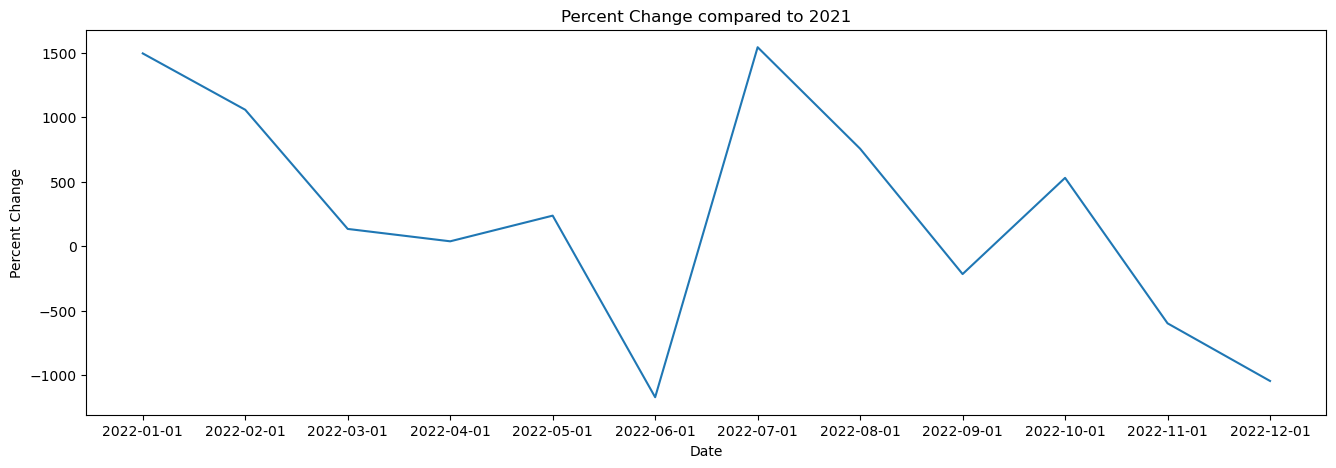

In [18]:
prev_year_pct=[]

for i in range(0, len(month_dfs)):
    prev_year_pct.append(percent_change_year(month_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

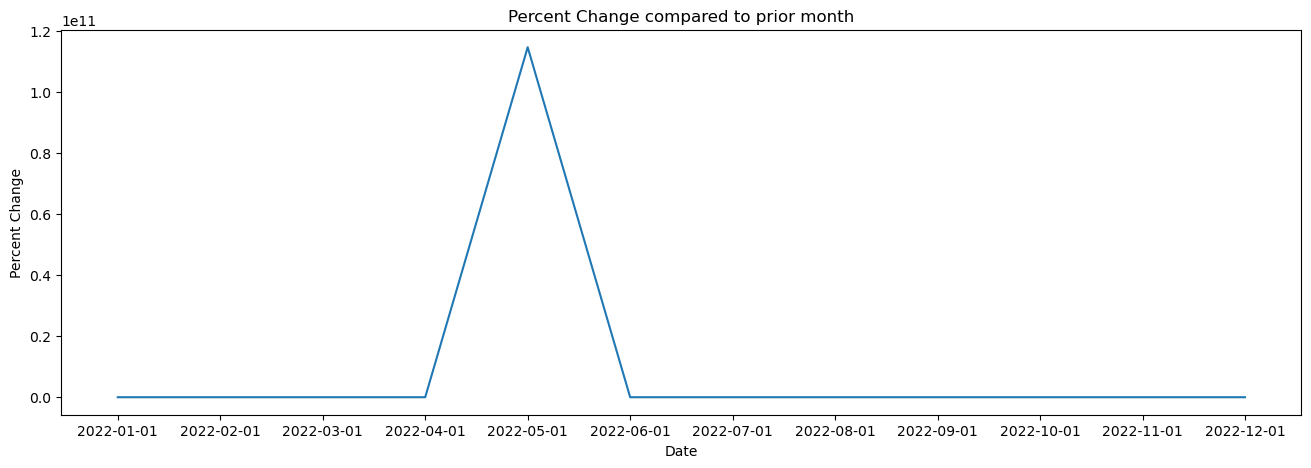

In [19]:
prev_month_pct=[]

for i in range(0, len(month_dfs)):
    prev_month_pct.append(percent_change_month(month_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## West Yellowstone Accomodations

In [21]:
accomodation_naics = '721'
mask = [ str(ncode)[:3]==accomodation_naics for ncode in list(df_weyel_poi['NAICS_CODE']) ]
df_hotels_pois = df_weyel_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_weyel_hotels = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_hotels_pois['PLACEKEY'])]

df_hotel_before = time_filt(df_weyel_hotels, before_flood_start, before_flood_end)
print(df_hotel_before.head(5), '\n')

df_hotel_during = time_filt(df_weyel_hotels, during_flood_start, during_flood_end)
print(df_hotel_during.head(5), '\n')

df_hotel_after = time_filt(df_weyel_hotels, after_flood_start, after_flood_end)
print(df_hotel_after.head(5), '\n')

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND          TRANSACTION_INTERMEDIARY         SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_CROSS_SHOPPI

DATE
2022-06-03     331.40
2022-06-04     537.24
2022-06-05     403.76
2022-06-06    5873.33
2022-06-07    2419.20
2022-06-08    2404.78
2022-06-09     831.98
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     2595.04
2022-06-11      649.47
2022-06-12     2409.44
2022-06-13    14675.28
2022-06-14      556.40
2022-06-15     1179.71
2022-06-16      324.00
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    1561.88
2022-06-18       0.00
2022-06-19     215.98
2022-06-20     268.68
2022-06-21     303.39
2022-06-22       0.00
2022-06-23       0.00
Name: SPEND_BY_DAY, dtype: float64


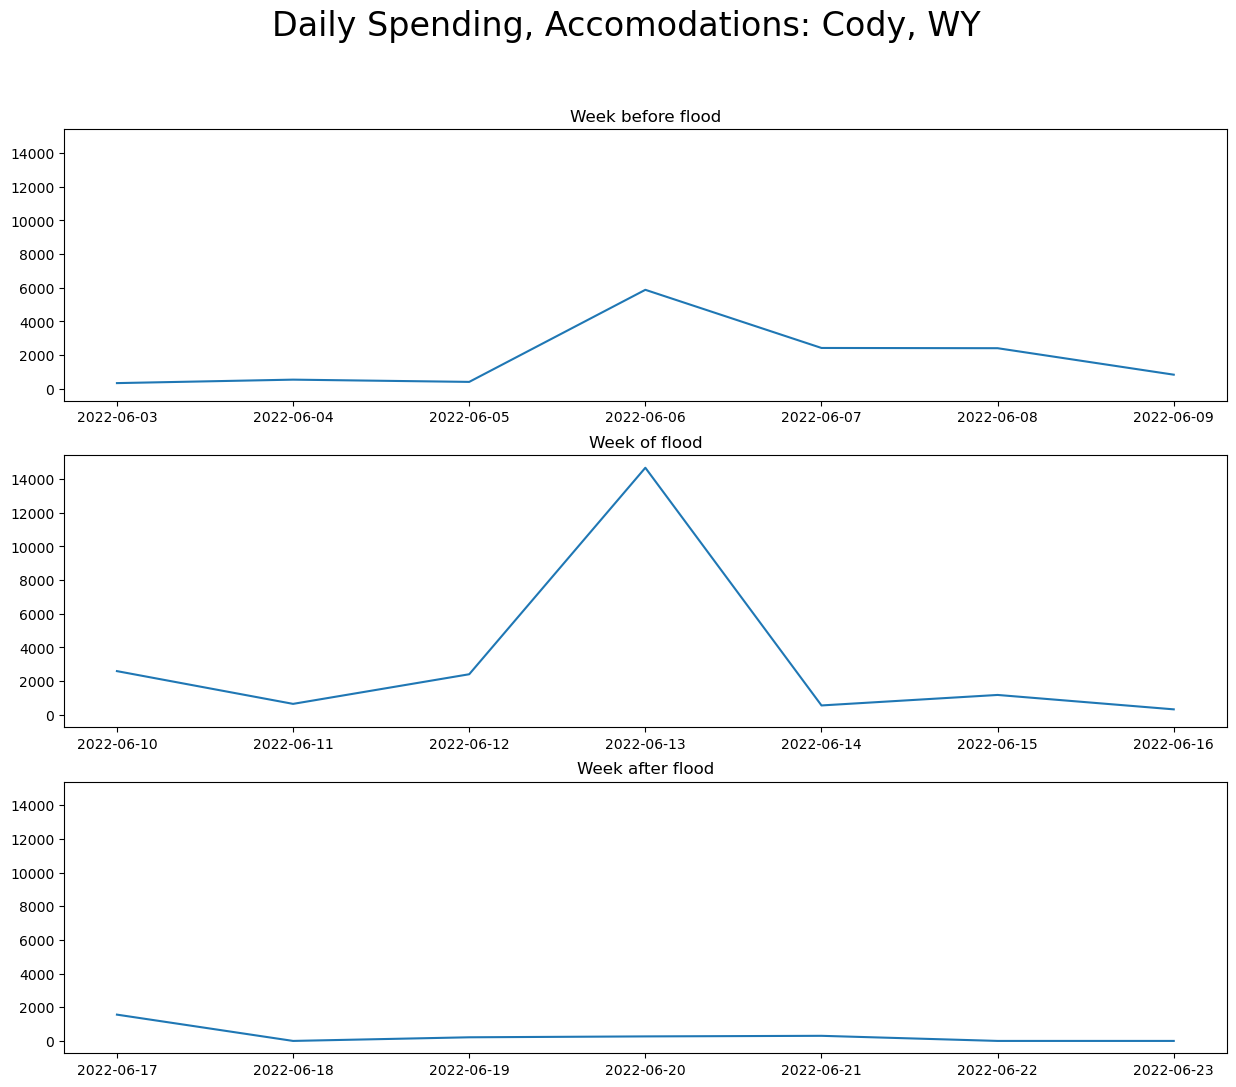

In [22]:
df_hotel_flood = time_filt(df_weyel_hotels, '2022-05-01', '2022-08-01')
df_flood_spending_hotels = spend_by_day(df_hotel_flood)

before_flood_hotels = df_flood_spending_hotels[33:40]
during_flood_hotels = df_flood_spending_hotels[40:47]
after_flood_hotels = df_flood_spending_hotels[47:54]
print(before_flood_hotels)
print(during_flood_hotels)
print(after_flood_hotels)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_hotels)
ax1.set_title('Week before flood');
ax2.plot(during_flood_hotels)
ax2.set_title('Week of flood');
ax3.plot(after_flood_hotels)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Accomodations: Cody, WY', fontsize='24');

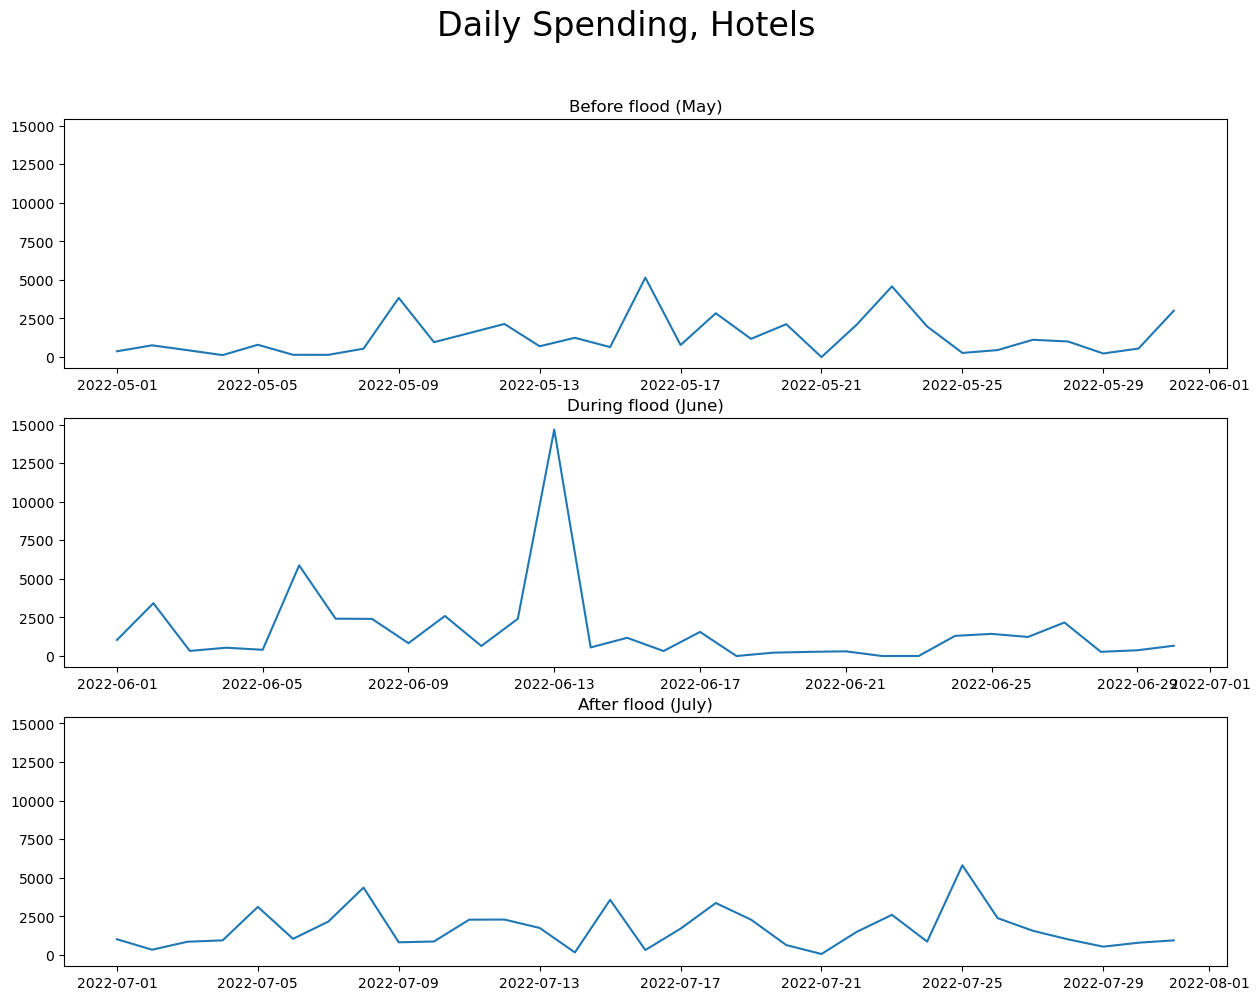

In [23]:
df_spend_before_hotel = spend_by_day(df_hotel_before)
df_spend_during_hotel = spend_by_day(df_hotel_during)
df_spend_after_hotel = spend_by_day(df_hotel_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_hotel)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_hotel)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_hotel)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Hotels', fontsize='24');

Before Flooding: 
Out of state:  175
In state:  6
Percentage out of state: 96.68508287292818 %


During Flooding: 
Out of state:  150
In state:  10
Percentage out of state: 93.75 %


After Flooding: 
Out of state:  187
In state:  6
Percentage out of state: 96.89119170984456 %




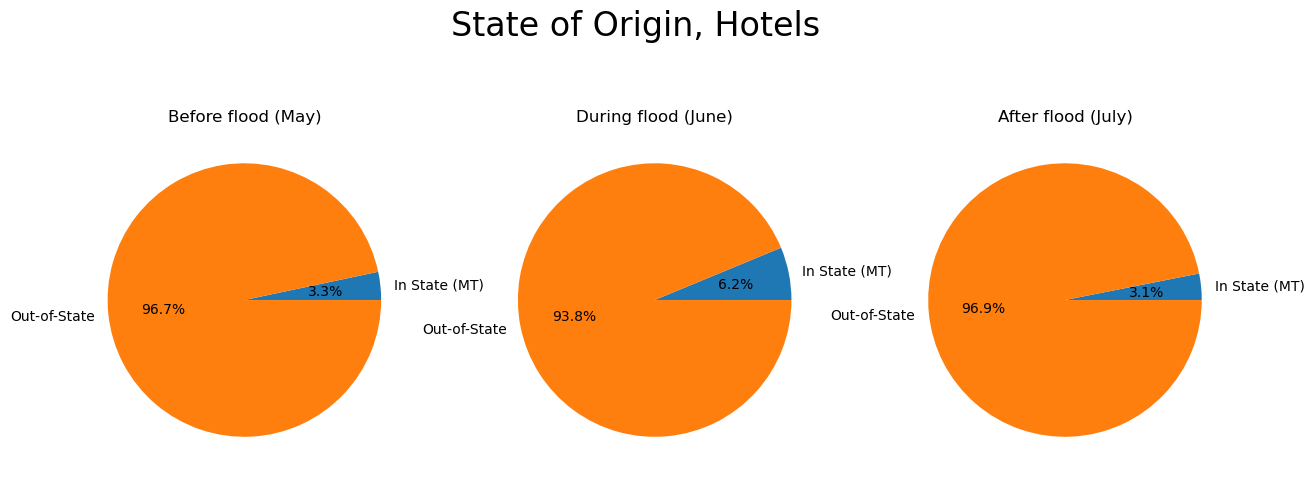

In [24]:
print('Before Flooding: ')
before = percent_instate(df_hotel_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_hotel_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_hotel_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Hotels', fontsize='24');

In [25]:
df_hotel_jan = time_filt(df_weyel_hotels, month[0], month[1])
df_hotel_feb = time_filt(df_weyel_hotels, month[1], month[2])
df_hotel_mar = time_filt(df_weyel_hotels, month[2], month[3])
df_hotel_apr = time_filt(df_weyel_hotels, month[3], month[4])
df_hotel_may = time_filt(df_weyel_hotels, month[4], month[5])
df_hotel_jun = time_filt(df_weyel_hotels, month[5], month[6])
df_hotel_jul = time_filt(df_weyel_hotels, month[6], month[7])
df_hotel_aug = time_filt(df_weyel_hotels, month[7], month[8])
df_hotel_sep = time_filt(df_weyel_hotels, month[8], month[9])
df_hotel_oct = time_filt(df_weyel_hotels, month[9], month[10])
df_hotel_nov = time_filt(df_weyel_hotels, month[10], month[11])
df_hotel_dec = time_filt(df_weyel_hotels, month[11], month[12])

hotel_dfs = [df_hotel_jan, df_hotel_feb, df_hotel_mar, df_hotel_apr, df_hotel_may, df_hotel_jun, 
             df_hotel_jul, df_hotel_aug, df_hotel_sep, df_hotel_oct, df_hotel_nov, df_hotel_dec]

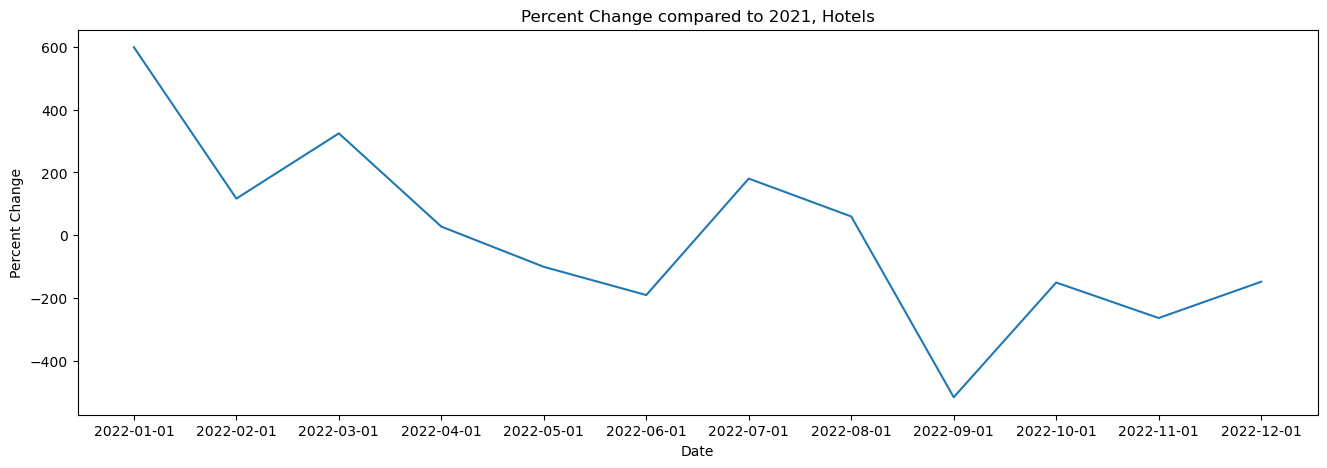

In [26]:
prev_year_pct=[]

for i in range(0, len(hotel_dfs)):
    prev_year_pct.append(percent_change_year(hotel_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Hotels');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

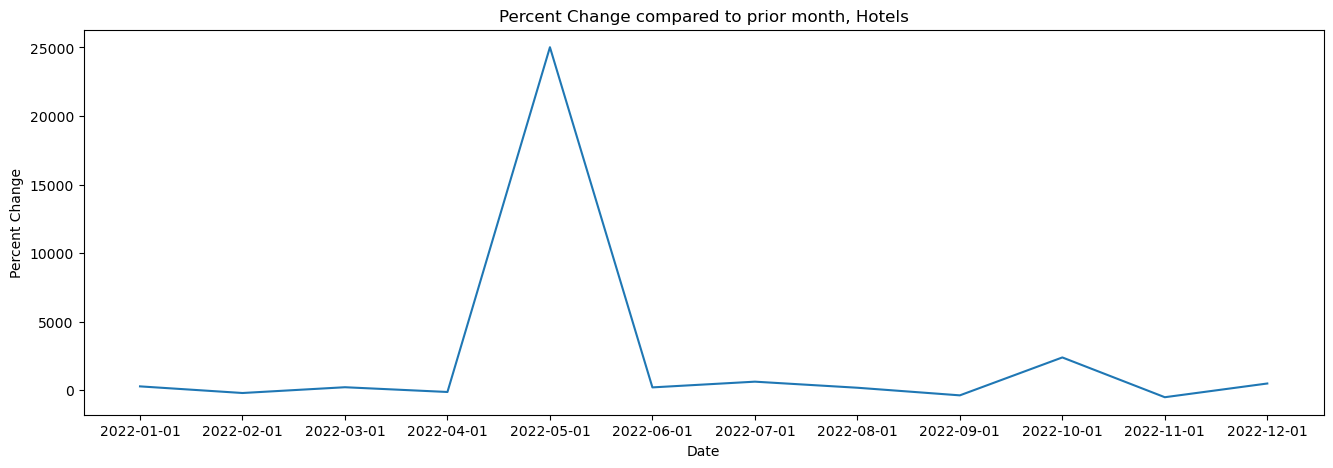

In [27]:
prev_month_pct=[]

for i in range(0, len(hotel_dfs)):
    prev_month_pct.append(percent_change_month(hotel_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Hotels');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## West Yellowstone Food

In [28]:
food_naics = '722'
mask = [ str(ncode)[:3]==food_naics for ncode in list(df_weyel_poi['NAICS_CODE']) ]
df_food_pois = df_weyel_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_weyel_food = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_food_pois['PLACEKEY'])]

df_food_before = time_filt(df_weyel_food, before_flood_start, before_flood_end)
print(df_food_before.head(5), '\n')

df_food_during = time_filt(df_weyel_food, during_flood_start, during_flood_end)
print(df_food_during.head(5), '\n')

df_food_after = time_filt(df_weyel_food, after_flood_start, after_flood_end)
print(df_food_after.head(5), '\n')

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                    BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_CROSS_SHOPPING_SAME_CATEGOR

DATE
2022-06-03    2893.81
2022-06-04    2199.43
2022-06-05    3619.92
2022-06-06    6344.37
2022-06-07    4196.40
2022-06-08    3893.18
2022-06-09    4772.17
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     4638.14
2022-06-11     1778.35
2022-06-12     3683.71
2022-06-13    15415.65
2022-06-14     4099.01
2022-06-15     2385.05
2022-06-16     2961.78
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17     2469.75
2022-06-18     1765.78
2022-06-19     2770.50
2022-06-20     2006.21
2022-06-21    11415.44
2022-06-22     2378.50
2022-06-23     1991.92
Name: SPEND_BY_DAY, dtype: float64


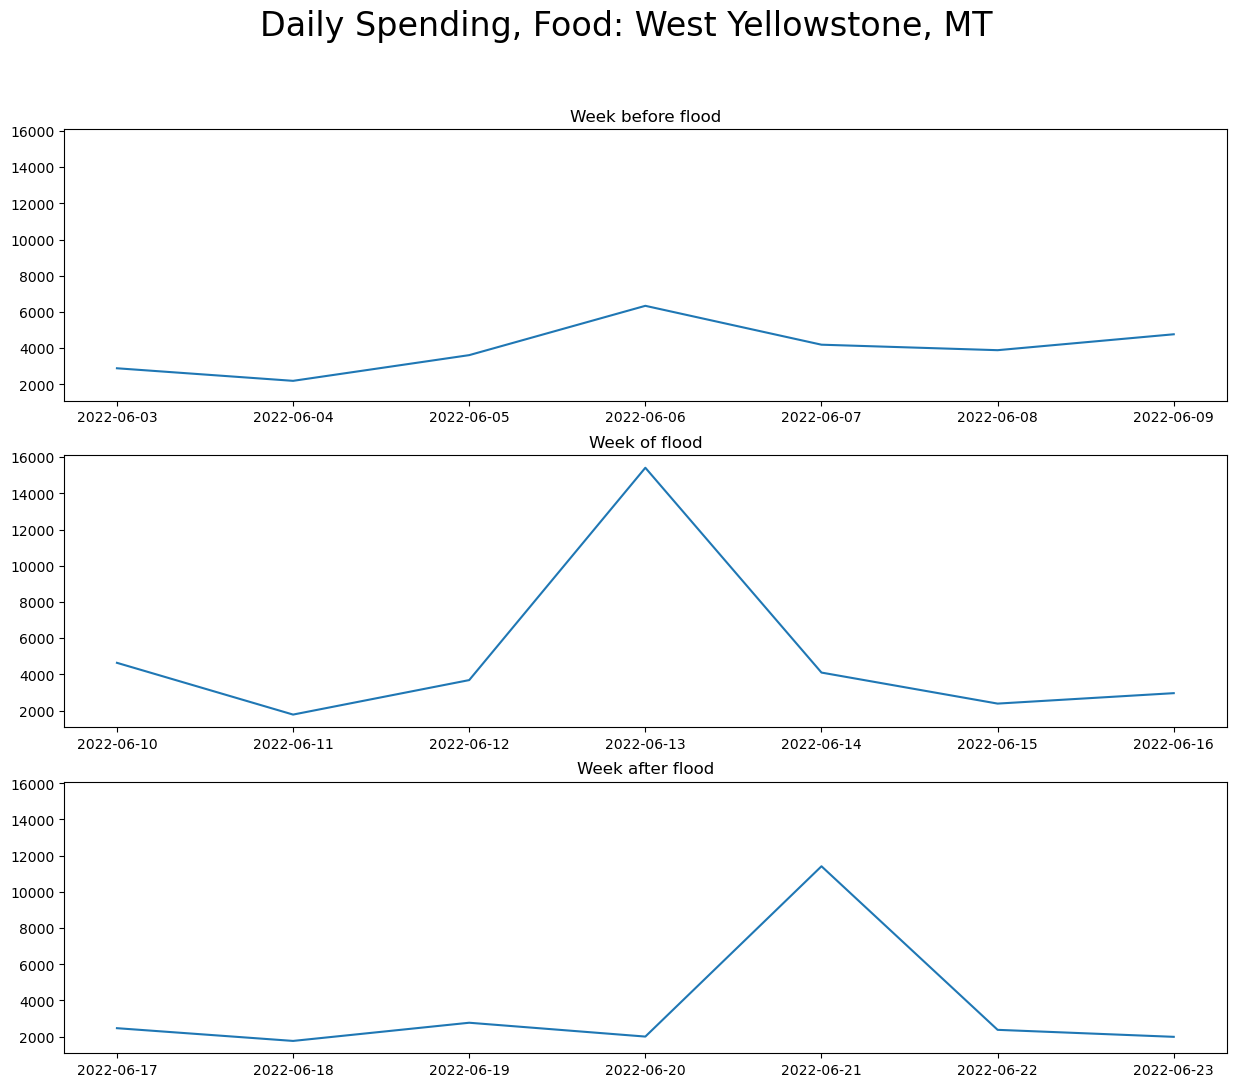

In [30]:
df_food_flood = time_filt(df_weyel_food, '2022-05-01', '2022-08-01')
df_flood_spending_food = spend_by_day(df_food_flood)

before_flood_food = df_flood_spending_food[33:40]
during_flood_food = df_flood_spending_food[40:47]
after_flood_food = df_flood_spending_food[47:54]
print(before_flood_food)
print(during_flood_food)
print(after_flood_food)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_food)
ax1.set_title('Week before flood');
ax2.plot(during_flood_food)
ax2.set_title('Week of flood');
ax3.plot(after_flood_food)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Food: West Yellowstone, MT', fontsize='24');

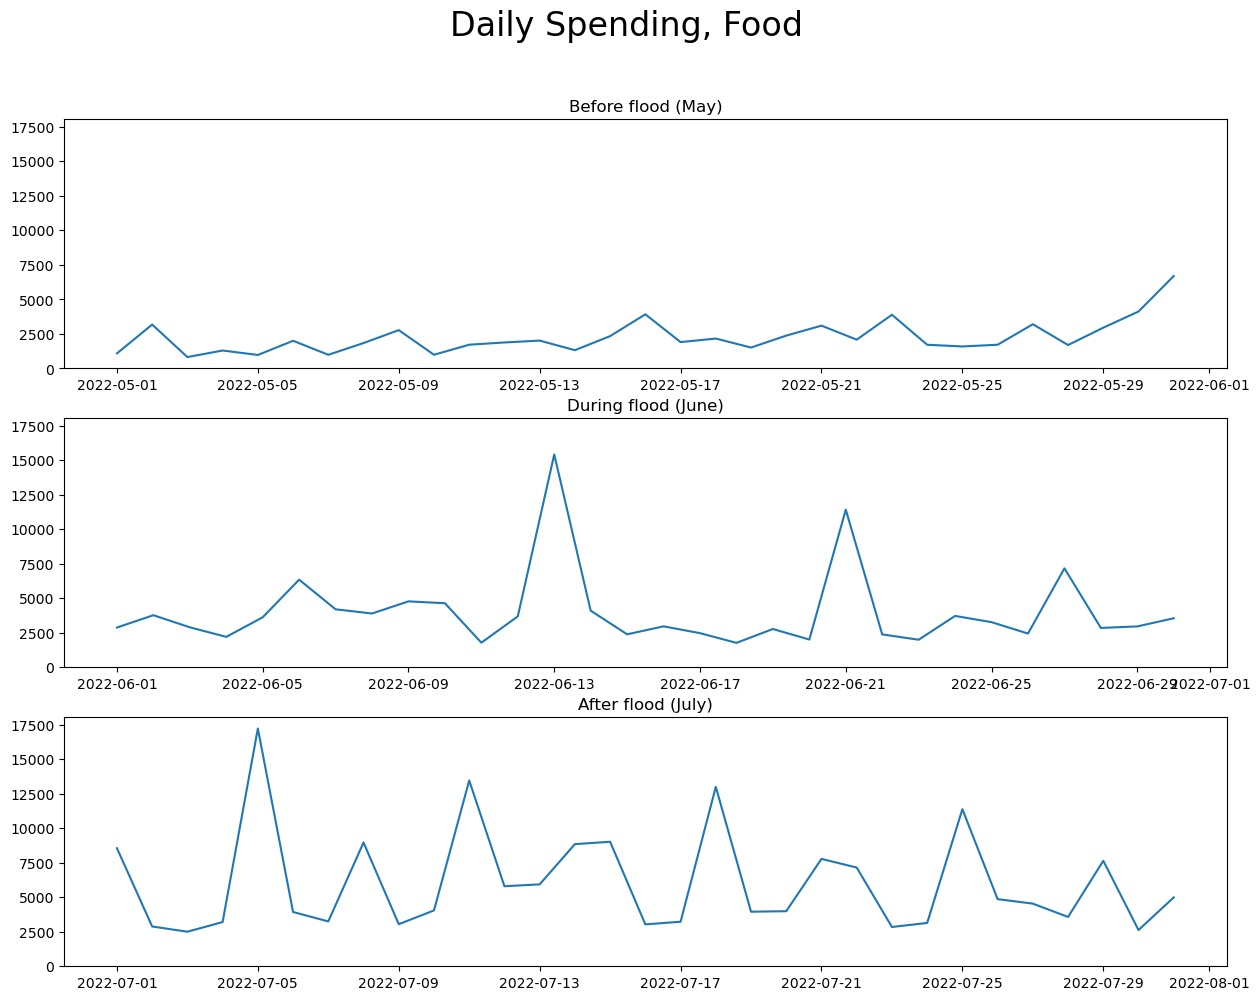

In [31]:
df_spend_before_food = spend_by_day(df_food_before)
df_spend_during_food = spend_by_day(df_food_during)
df_spend_after_food = spend_by_day(df_food_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_food)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_food)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_food)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Food', fontsize='24');

Before Flooding: 
Out of state:  2024
In state:  121
Percentage out of state: 94.35897435897435 %


During Flooding: 
Out of state:  3023
In state:  148
Percentage out of state: 95.33270261747083 %


After Flooding: 
Out of state:  3611
In state:  263
Percentage out of state: 93.21115126484254 %




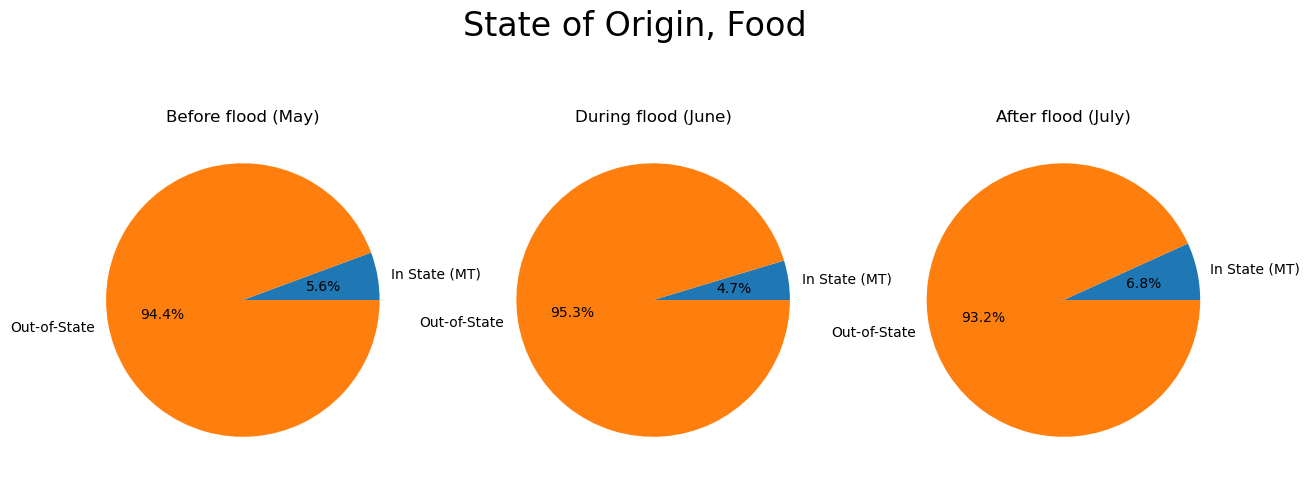

In [32]:
print('Before Flooding: ')
before = percent_instate(df_food_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_food_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_food_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Food', fontsize='24');

In [33]:
df_food_jan = time_filt(df_weyel_food, month[0], month[1])
df_food_feb = time_filt(df_weyel_food, month[1], month[2])
df_food_mar = time_filt(df_weyel_food, month[2], month[3])
df_food_apr = time_filt(df_weyel_food, month[3], month[4])
df_food_may = time_filt(df_weyel_food, month[4], month[5])
df_food_jun = time_filt(df_weyel_food, month[5], month[6])
df_food_jul = time_filt(df_weyel_food, month[6], month[7])
df_food_aug = time_filt(df_weyel_food, month[7], month[8])
df_food_sep = time_filt(df_weyel_food, month[8], month[9])
df_food_oct = time_filt(df_weyel_food, month[9], month[10])
df_food_nov = time_filt(df_weyel_food, month[10], month[11])
df_food_dec = time_filt(df_weyel_food, month[11], month[12])

food_dfs = [df_food_jan, df_food_feb, df_food_mar, df_food_apr, df_food_may, df_food_jun, 
             df_food_jul, df_food_aug, df_food_sep, df_food_oct, df_food_nov, df_food_dec]

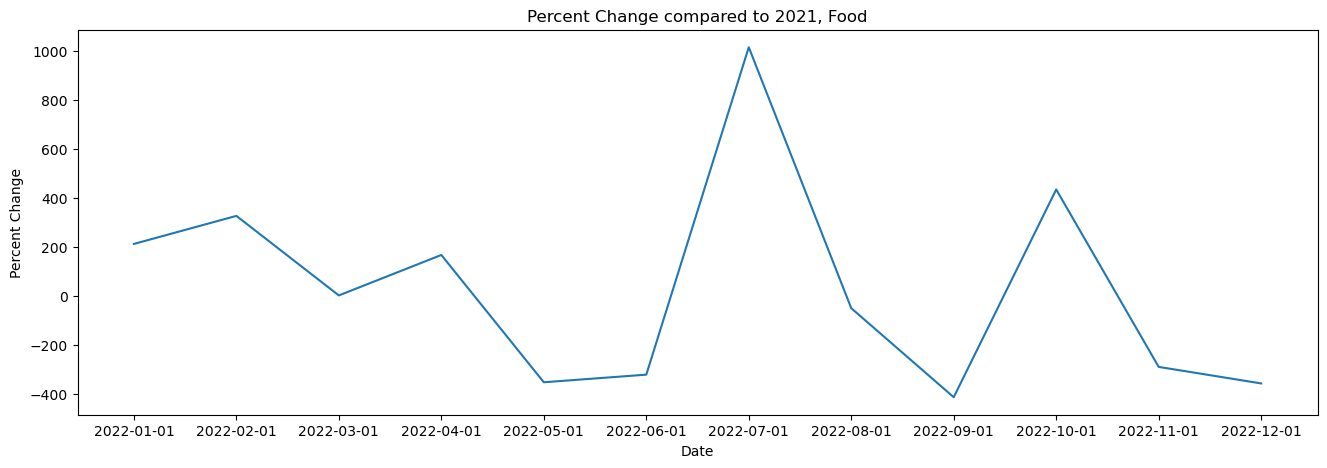

In [34]:
prev_year_pct=[]

for i in range(0, len(food_dfs)):
    prev_year_pct.append(percent_change_year(food_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Food');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

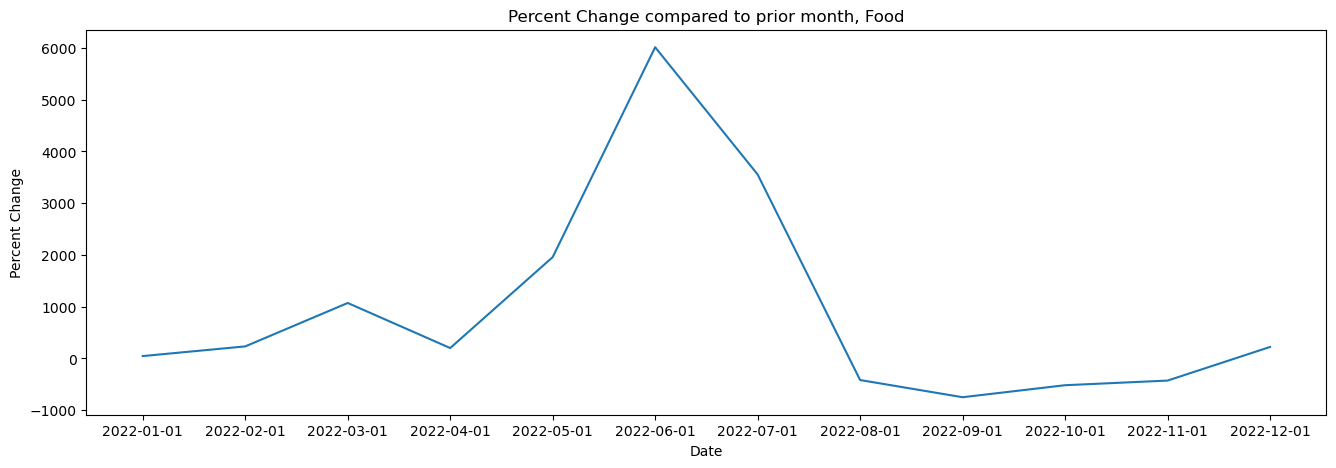

In [35]:
prev_month_pct=[]

for i in range(0, len(food_dfs)):
    prev_month_pct.append(percent_change_month(food_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Food');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## West Yellowstone Retail

In [36]:
retail_naics = ['452', '445', '451', '448', '446', '711', '712', '713']
combined_mask = np.zeros(len(df_weyel_poi),dtype=bool)
for i in retail_naics:
    mask = [ str(ncode)[:3]==i for ncode in list(df_weyel_poi['NAICS_CODE']) ]
    combined_mask += mask
df_retail_poi = df_weyel_poi[combined_mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_weyel_retail = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_retail_poi['PLACEKEY'])]

df_retail_before = time_filt(df_weyel_retail, before_flood_start, before_flood_end)
print(df_retail_before.head(5), '\n')

df_retail_during = time_filt(df_weyel_retail, during_flood_start, during_flood_end)
print(df_retail_during.head(5), '\n')

df_retail_after = time_filt(df_weyel_retail, after_flood_start, after_flood_end)
print(df_retail_after.head(5), '\n')

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_CROSS_SHOPPING_SAME_CATEGORY_

DATE
2022-06-03     407.58
2022-06-04    1151.79
2022-06-05      76.02
2022-06-06     320.22
2022-06-07     222.86
2022-06-08     383.89
2022-06-09     452.82
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     256.65
2022-06-11     650.80
2022-06-12      66.54
2022-06-13    1028.76
2022-06-14      73.14
2022-06-15     340.71
2022-06-16     351.14
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    869.70
2022-06-18    493.38
2022-06-19    239.49
2022-06-20    431.26
2022-06-21    129.76
2022-06-22    412.38
2022-06-23    120.17
Name: SPEND_BY_DAY, dtype: float64


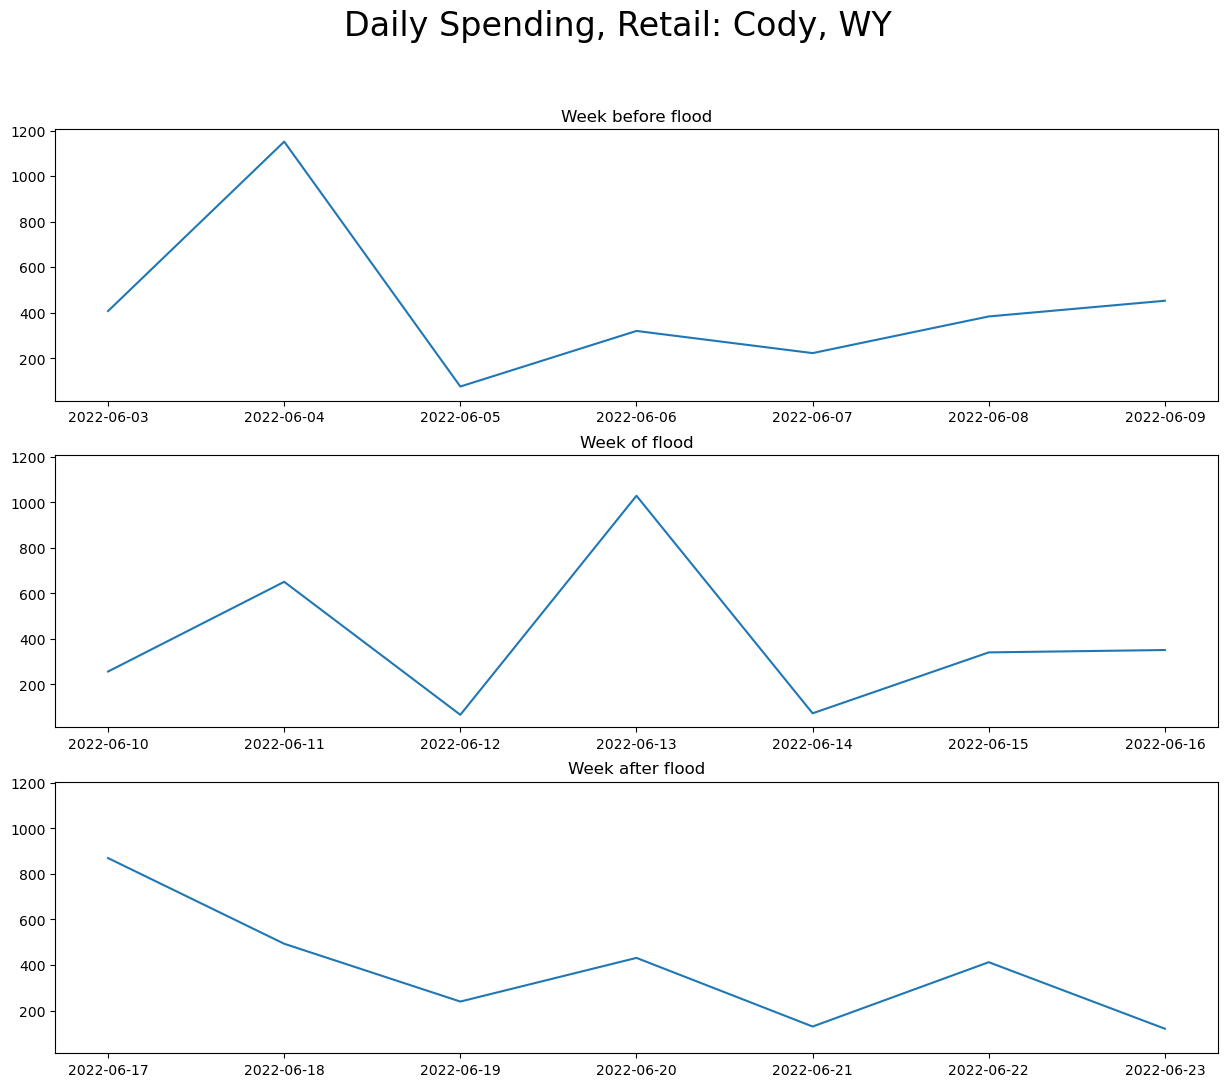

In [37]:
df_retail_flood = time_filt(df_weyel_retail, '2022-05-01', '2022-08-01')
df_flood_spending_retail = spend_by_day(df_retail_flood)

before_flood_retail = df_flood_spending_retail[33:40]
during_flood_retail = df_flood_spending_retail[40:47]
after_flood_retail = df_flood_spending_retail[47:54]
print(before_flood_retail)
print(during_flood_retail)
print(after_flood_retail)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_retail)
ax1.set_title('Week before flood');
ax2.plot(during_flood_retail)
ax2.set_title('Week of flood');
ax3.plot(after_flood_retail)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Retail: Cody, WY', fontsize='24');

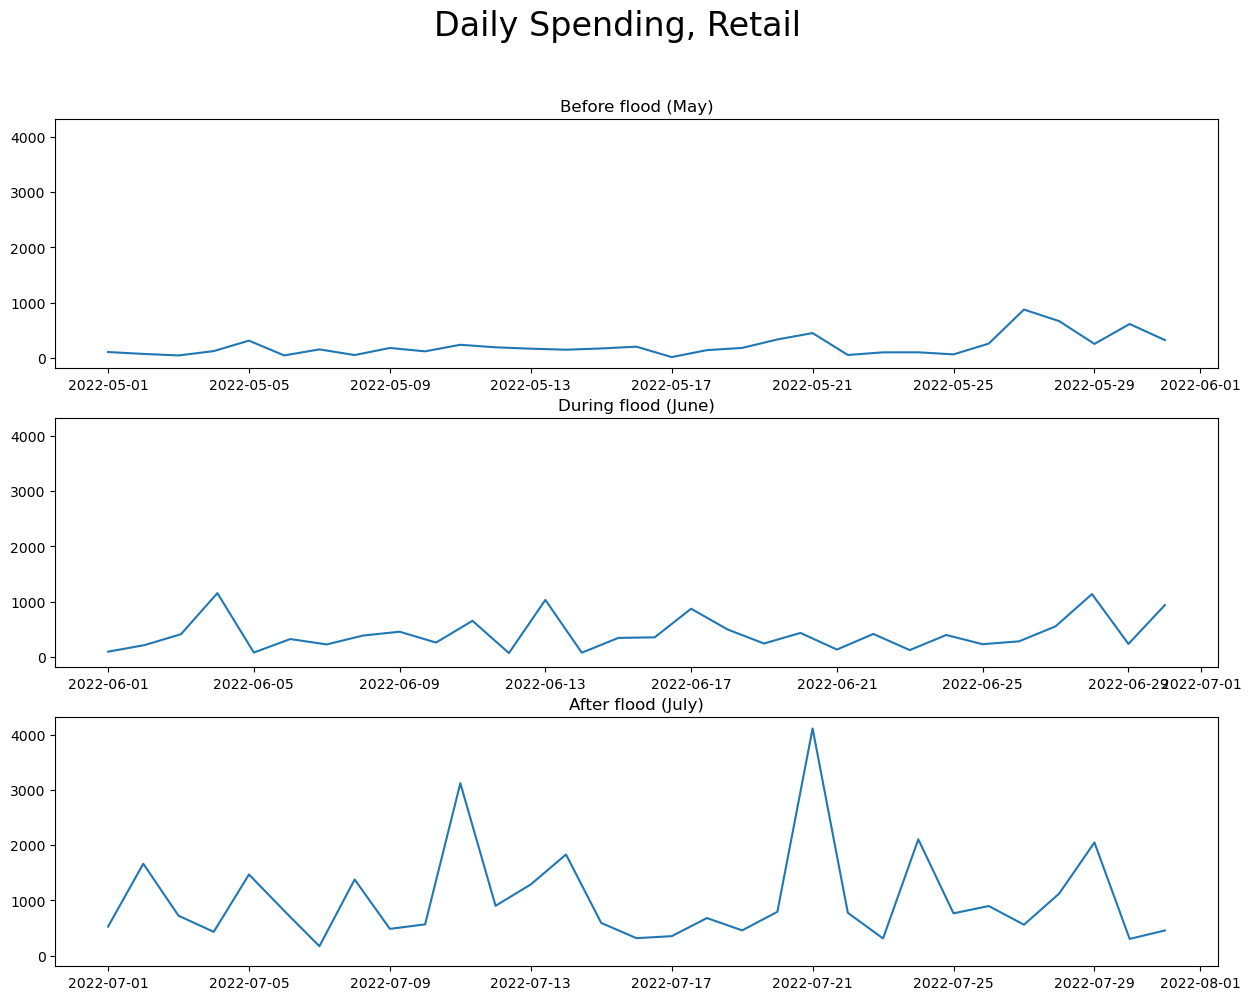

In [38]:
df_spend_before_retail = spend_by_day(df_retail_before)
df_spend_during_retail = spend_by_day(df_retail_during)
df_spend_after_retail = spend_by_day(df_retail_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_retail)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_retail)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_retail)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Retail', fontsize='24');

Before Flooding: 
Out of state:  181
In state:  16
Percentage out of state: 91.87817258883248 %


During Flooding: 
Out of state:  267
In state:  21
Percentage out of state: 92.70833333333334 %


After Flooding: 
Out of state:  389
In state:  36
Percentage out of state: 91.52941176470588 %




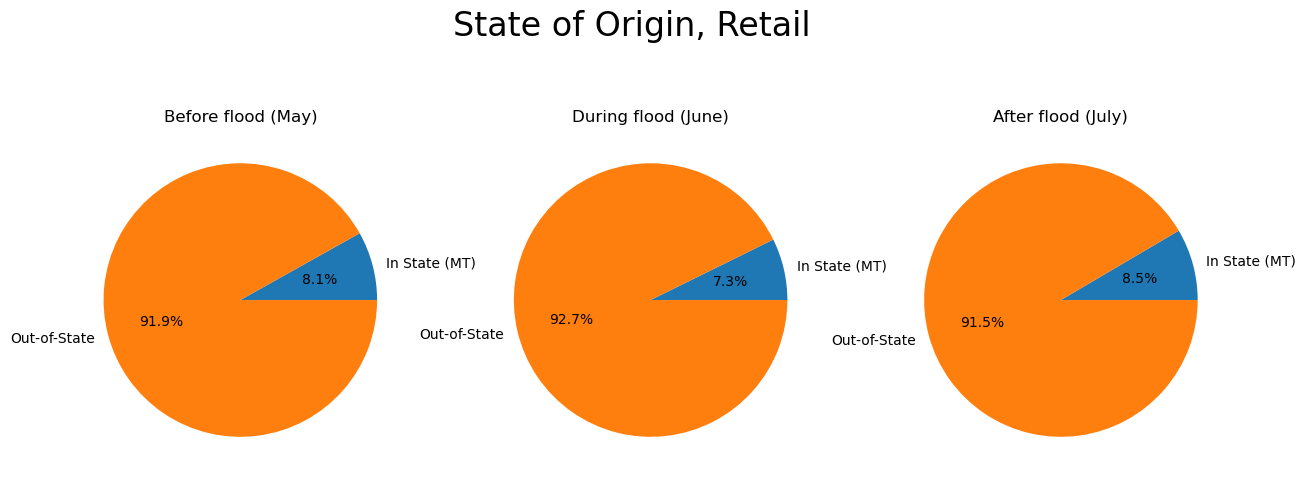

In [39]:
print('Before Flooding: ')
before = percent_instate(df_retail_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_retail_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_retail_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Retail', fontsize='24');

In [40]:
df_retail_jan = time_filt(df_weyel_retail, month[0], month[1])
df_retail_feb = time_filt(df_weyel_retail, month[1], month[2])
df_retail_mar = time_filt(df_weyel_retail, month[2], month[3])
df_retail_apr = time_filt(df_weyel_retail, month[3], month[4])
df_retail_may = time_filt(df_weyel_retail, month[4], month[5])
df_retail_jun = time_filt(df_weyel_retail, month[5], month[6])
df_retail_jul = time_filt(df_weyel_retail, month[6], month[7])
df_retail_aug = time_filt(df_weyel_retail, month[7], month[8])
df_retail_sep = time_filt(df_weyel_retail, month[8], month[9])
df_retail_oct = time_filt(df_weyel_retail, month[9], month[10])
df_retail_nov = time_filt(df_weyel_retail, month[10], month[11])
df_retail_dec = time_filt(df_weyel_retail, month[11], month[12])

retail_dfs = [df_retail_jan, df_retail_feb, df_retail_mar, df_retail_apr, df_retail_may, df_retail_jun, 
             df_retail_jul, df_retail_aug, df_retail_sep, df_retail_oct, df_retail_nov, df_retail_dec]

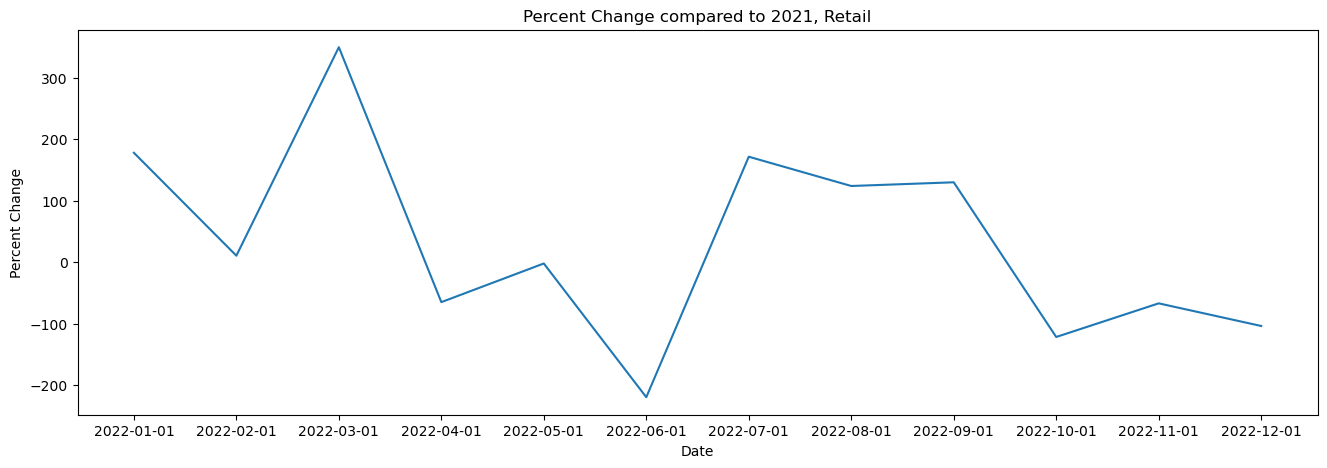

In [41]:
prev_year_pct=[]

for i in range(0, len(retail_dfs)):
    prev_year_pct.append(percent_change_year(retail_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Retail');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

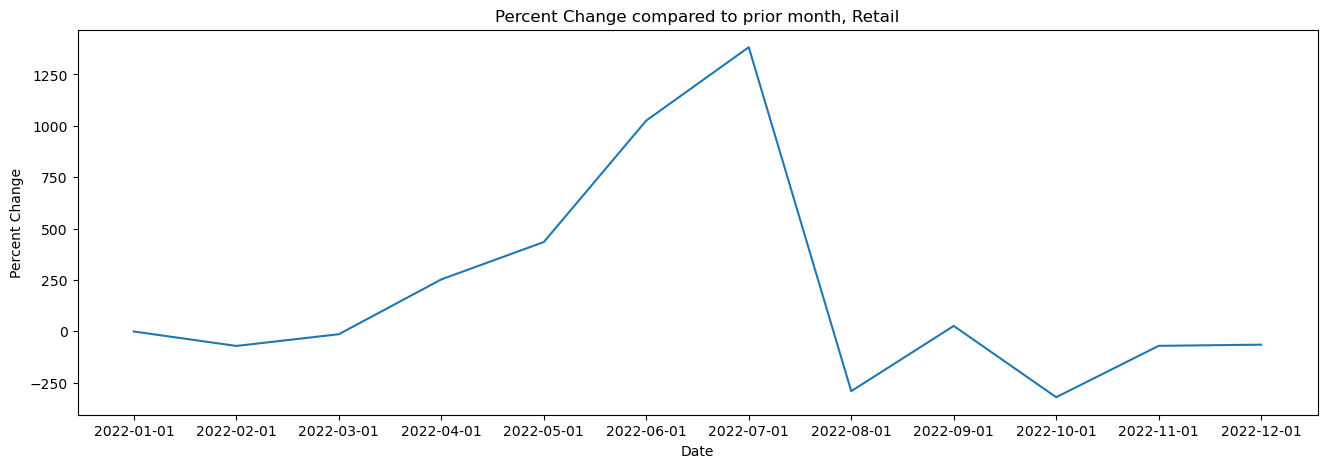

In [42]:
prev_month_pct=[]

for i in range(0, len(retail_dfs)):
    prev_month_pct.append(percent_change_month(retail_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Retail');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## West Yellowstone Transportation

In [43]:
transit_naics = ['447', '485', '481']
combined_mask = np.zeros(len(df_weyel_poi),dtype=bool)
for i in transit_naics:
    mask = [ str(ncode)[:3]==i for ncode in list(df_weyel_poi['NAICS_CODE']) ]
    combined_mask += mask
df_transit_poi = df_weyel_poi[combined_mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_weyel_transit = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_transit_poi['PLACEKEY'])]

df_transit_before = time_filt(df_weyel_transit, before_flood_start, before_flood_end)
print(df_transit_before.head(5), '\n')

df_transit_during = time_filt(df_weyel_transit, during_flood_start, during_flood_end)
print(df_transit_during.head(5), '\n')

df_transit_after = time_filt(df_weyel_transit, after_flood_start, after_flood_end)
print(df_transit_after.head(5), '\n')

                   PLACEKEY                        SAFEGRAPH_BRAND_IDS          BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                    BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    REL

DATE
2022-06-03    1582.18
2022-06-04    1235.49
2022-06-05     940.59
2022-06-06    1676.90
2022-06-07    1426.02
2022-06-08    1361.27
2022-06-09    1344.03
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10    1380.67
2022-06-11    1177.21
2022-06-12    1271.74
2022-06-13    1328.02
2022-06-14     861.41
2022-06-15     474.33
2022-06-16     502.05
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    271.89
2022-06-18    535.39
2022-06-19    806.61
2022-06-20    655.31
2022-06-21    776.12
2022-06-22    939.55
2022-06-23    805.57
Name: SPEND_BY_DAY, dtype: float64


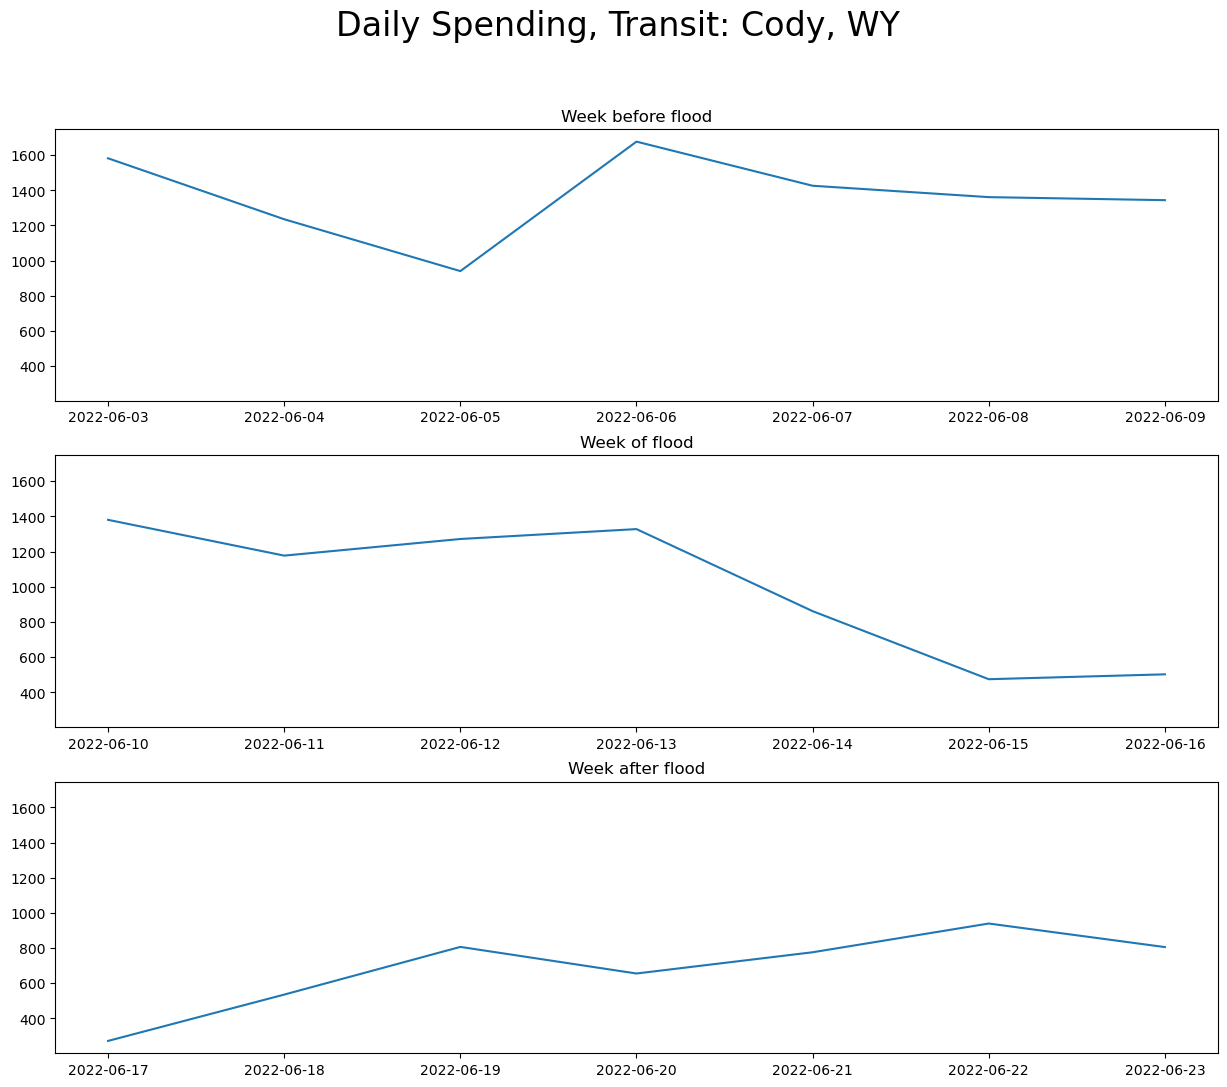

In [44]:
df_transit_flood = time_filt(df_weyel_transit, '2022-05-01', '2022-08-01')
df_flood_spending_transit = spend_by_day(df_transit_flood)

before_flood_transit = df_flood_spending_transit[33:40]
during_flood_transit = df_flood_spending_transit[40:47]
after_flood_transit = df_flood_spending_transit[47:54]
print(before_flood_transit)
print(during_flood_transit)
print(after_flood_transit)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_transit)
ax1.set_title('Week before flood');
ax2.plot(during_flood_transit)
ax2.set_title('Week of flood');
ax3.plot(after_flood_transit)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Transit: Cody, WY', fontsize='24');

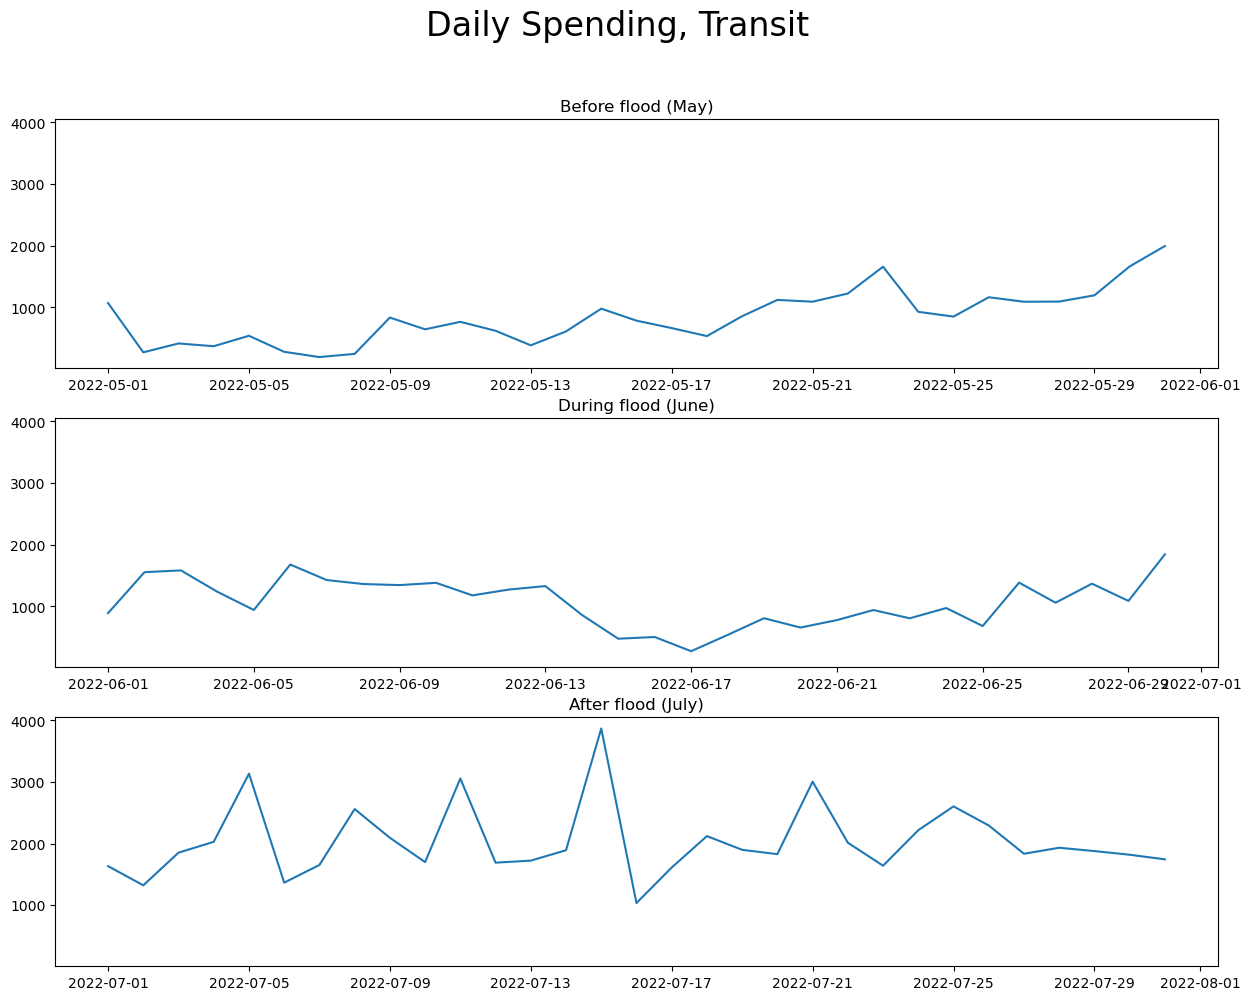

In [45]:
df_spend_before_transit = spend_by_day(df_transit_before)
df_spend_during_transit = spend_by_day(df_transit_during)
df_spend_after_transit = spend_by_day(df_transit_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_transit)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_transit)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_transit)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Transit', fontsize='24');

Before Flooding: 
Out of state:  713
In state:  43
Percentage out of state: 94.31216931216932 %


During Flooding: 
Out of state:  888
In state:  41
Percentage out of state: 95.58665231431647 %


After Flooding: 
Out of state:  1457
In state:  101
Percentage out of state: 93.51732991014121 %




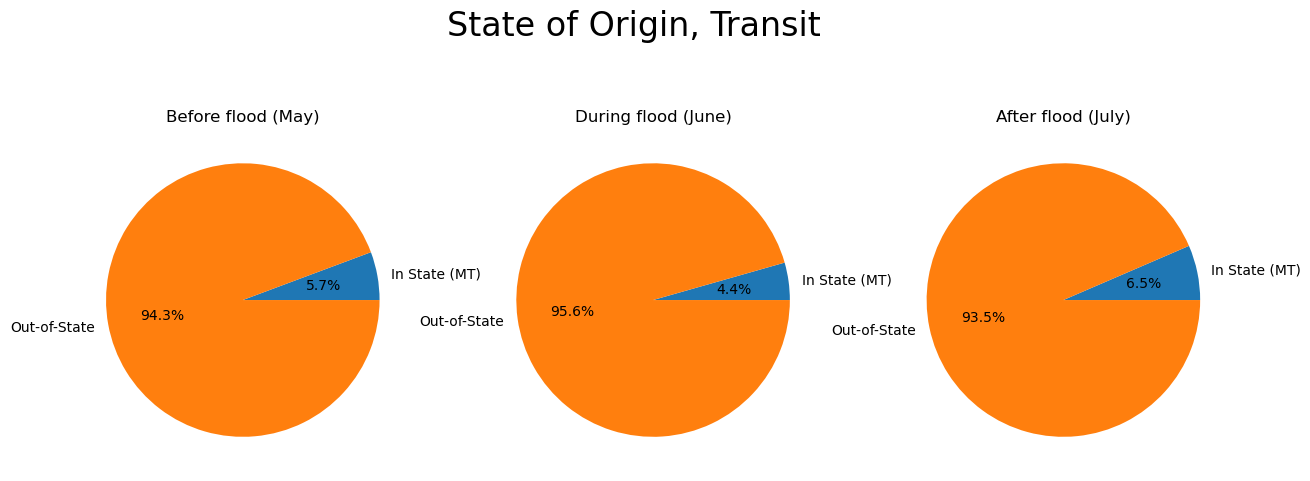

In [46]:
print('Before Flooding: ')
before = percent_instate(df_transit_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_transit_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_transit_after)
print('\n')

labels = 'In State (MT)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Transit', fontsize='24');

In [47]:
df_transit_jan = time_filt(df_weyel_transit, month[0], month[1])
df_transit_feb = time_filt(df_weyel_transit, month[1], month[2])
df_transit_mar = time_filt(df_weyel_transit, month[2], month[3])
df_transit_apr = time_filt(df_weyel_transit, month[3], month[4])
df_transit_may = time_filt(df_weyel_transit, month[4], month[5])
df_transit_jun = time_filt(df_weyel_transit, month[5], month[6])
df_transit_jul = time_filt(df_weyel_transit, month[6], month[7])
df_transit_aug = time_filt(df_weyel_transit, month[7], month[8])
df_transit_sep = time_filt(df_weyel_transit, month[8], month[9])
df_transit_oct = time_filt(df_weyel_transit, month[9], month[10])
df_transit_nov = time_filt(df_weyel_transit, month[10], month[11])
df_transit_dec = time_filt(df_weyel_transit, month[11], month[12])

transit_dfs = [df_transit_jan, df_transit_feb, df_transit_mar, df_transit_apr, df_transit_may, df_transit_jun, 
             df_transit_jul, df_transit_aug, df_transit_sep, df_transit_oct, df_transit_nov, df_transit_dec]

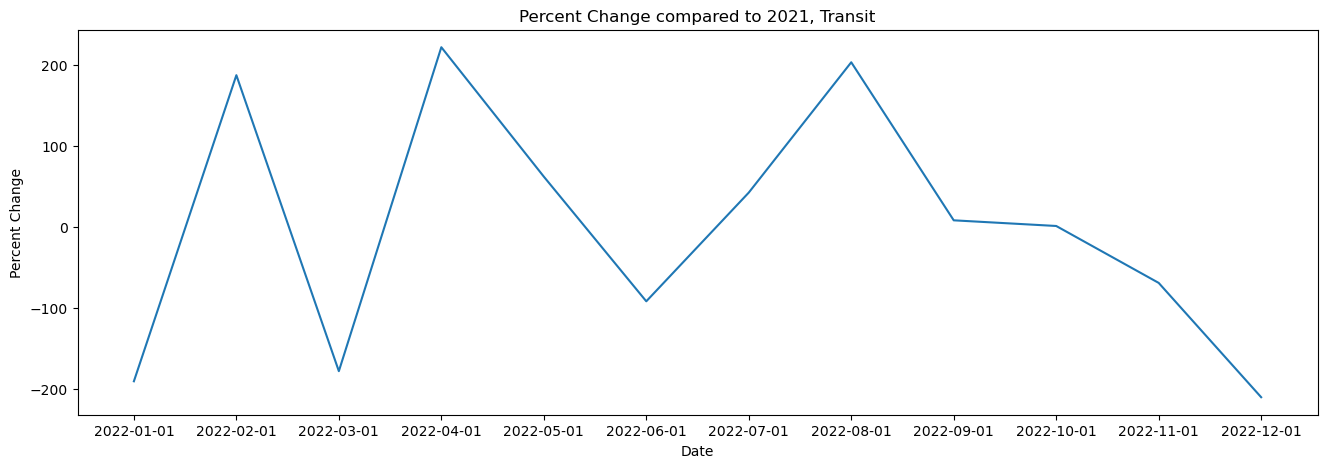

In [48]:
prev_year_pct=[]

for i in range(0, len(transit_dfs)):
    prev_year_pct.append(percent_change_year(transit_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Transit');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

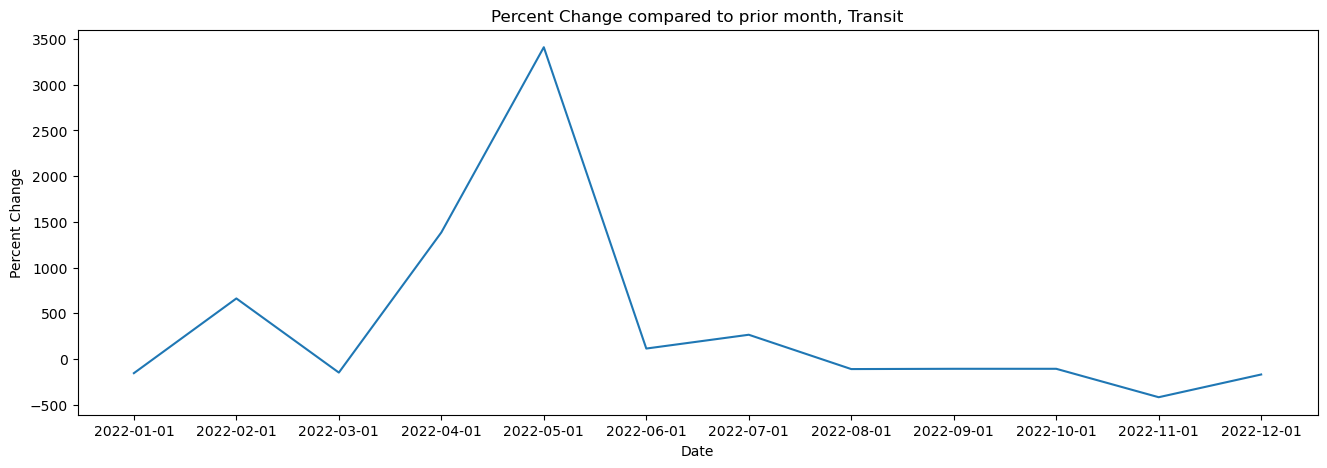

In [49]:
prev_month_pct=[]

for i in range(0, len(transit_dfs)):
    prev_month_pct.append(percent_change_month(transit_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Transit');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Aggregate

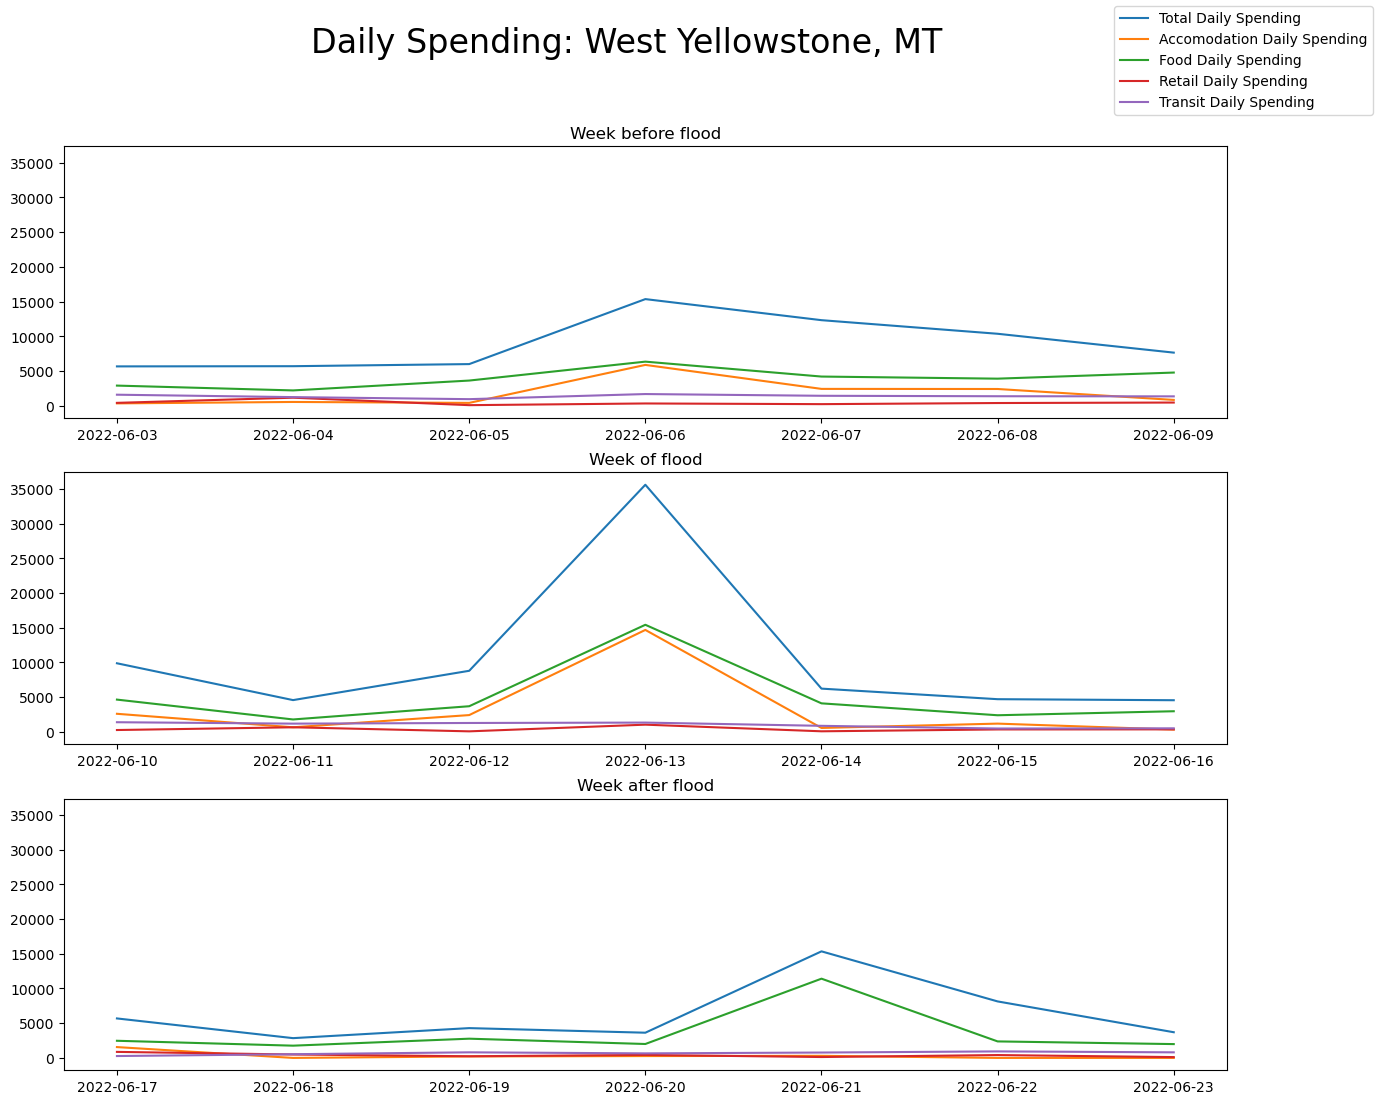

In [50]:
fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood, label='Total Daily Spending')
ax1.plot(before_flood_hotels, label='Accomodation Daily Spending');
ax1.plot(before_flood_food, label='Food Daily Spending')
ax1.plot(before_flood_retail, label='Retail Daily Spending')
ax1.plot(before_flood_transit, label='Transit Daily Spending')
ax1.set_title('Week before flood');
ax2.plot(during_flood)
ax2.plot(during_flood_hotels)
ax2.plot(during_flood_food)
ax2.plot(during_flood_retail)
ax2.plot(during_flood_transit)
ax2.set_title('Week of flood');
ax3.plot(after_flood)
ax3.plot(after_flood_hotels)
ax3.plot(after_flood_food)
ax3.plot(after_flood_retail)
ax3.plot(after_flood_transit)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending: West Yellowstone, MT', fontsize='24');
fig.legend();